# Largest small polygon
[![largest_small_polygon.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/marcos-dv/geometry/largest_small_polygon.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/marcos-dv/geometry/largest_small_polygon.ipynb) [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/marcos-dv/geometry/largest_small_polygon.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/marcos-dv/geometry/largest_small_polygon.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/marcos-dv/geometry/largest_small_polygon.ipynb) [![Hits](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/marcos-dv/geometry/largest_small_polygon.ipynb)](https://colab.ampl.com)

Description: lecture about models for the Largest Small Polygon Problem

Tags: geometry, non-linear, amplpy, ipopt, educational

Notebook author: Marcos Dominguez Velad <<marcos@ampl.com>>

Model author: Marcos Dominguez Velad <<marcos@ampl.com>> et al.

References:
1. Bingane, C. (2022). *Largest small polygons: A sequential convex optimization approach*. Optimization Letters, 1-13.
2. Graham, R. L. (1975). *The largest small hexagon*. Journal of Combinatorial Theory, Series A, 18(2), 165-170.
3. Reinhardt, K. (1922). *Extremale Polygone gegebenen Durchmessers*. Jahresbericht der Deutschen Mathematiker-Vereinigung, 31, 251-270.
4. [Netlib repository](https://netlib.org/ampl/models/)

In [ ]:
# Install dependencies
%pip install -q amplpy

In [ ]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["open", "knitro"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

A small polygon is a unit diameter polygon. Finding the polygon with maximum area is known as the "Largest Small Polygon" (LSP) problem. We are proposing some non-linear formulations to find the small polygon that maximizes the area for a given number of sides to solve the problem computationally. This is an open geometry problem, so we are providing a computational and approximate way to tackle it. 

## Problem statement

Given a number *n*, find the n-sided polygon that has diameter one and that has the largest area among all diameter-one n-gons. The diameter of a polygon is the maximum distance between any two vertices in the polygon, and distances between points are assumed to be Euclidean distances.

### Some theoretical results

The LSP problem has been solved for odd number of sides. In 1922, Reinhardt showed that the optimal solution for $n = 2k+1$ is the regular n-gon. The area of the regular unit n-gon is:

$$\frac{n}{2}(sin\frac{\pi}{n}-tan\frac{\pi}{2n}) \text{ ,   when n is odd}$$

$$\frac{n}{8}sin\frac{2\pi}{n} \text{ ,   when n is even}$$

These are lower bounds for our problem, but the even one might be improved from the regular polygon of $n-1$ sides:

* Take the odd regular $n-1$-gon. Add a vertex (at distance 1) along the bisectriz of any angle.

* The obtained polygon will be larger than the even regular $n$-gon. This fact proves that the regular polygon is not optimal for $n \geq 6$.

Although LSP has not been solved for general even number of sides, there are some conjectures related to the solutions and variants of the problem that assume some kind of symmetry in terms of the *diameter graph* of the polygon (the diameter graph of a small polygon is the graph with the vertices of the polygon, where vertices are connected if and only if the distance between them is equal to 1).

## Model with polar coordinates

The problem can be stated and solved by describing the problem in an straightforward way, formulating a non linear problem in polar coordinates. We are proposing a similar model to the one in the [netlib repository](https://netlib.org/ampl/models/), an AMPL model (by David M. Gay) that started as a GAMS model by Francisco J. Prieto. This model solves the general *n* instance of the problem.

### Variables

If $(x_i, y_i)$ are the cartesian coordinates (real numbers) of the points, they will be the vertices of a small polygon if the distances between them are less or equal to 1.

* For all $i = 1..n, j = 1..i-1$, 

$$\sqrt{(x_i-x_j)^2+(y_i-y_j)^2} \leq 1$$

That is equivalent to:

$$(x_i-x_j)^2+(y_i-y_j)^2 \leq 1$$


### Compute area

Given the *n* vertices of a polygon, we can compute the area of the polygon by using the [Shoelace formula](https://en.wikipedia.org/wiki/Shoelace_formula), like a 2D determinant:

<figure>
  <img src="https://raw.githubusercontent.com/ampl/colab.ampl.com/master/authors/marcos-dv/geometry/imgs/rule.png" width="600" height="360">
</figure>

Example:

The area of the polygon defined with the vertices
{(-1,0), (0.2,1), (2,0.7), (2,-1)} is

<img src="https://raw.githubusercontent.com/ampl/colab.ampl.com/master/authors/marcos-dv/geometry/imgs/trapezoid.png" width="200" height="140">

$$\frac{1}{2}|-1\times1+0.2\times0.7+2\times(-1)+2\times0-0\times0.2-1\times2-0.7\times2-(-1)\times(-1)| = 3.63$$

The formula works when the points are sorted counter clock-wise or clock-wise, then, in order to use the formula is is necessary to ensure the order of the points along the perimeter. How could we impose an order among the vertices, so first vertex (x1, y1) is connected to the second (x2, y2), which at the same time is connected to (x3, y3)... and so on until closing the polygon?

$$\frac{1}{2}\sum_{i=1}^{n-1}(x_i \cdot y_{i+1} - y_i \cdot x_{i+1})+\frac{1}{2}(x_n \cdot y_1 - y_n \cdot x_1)$$

### Polar coordinates to sort vertices

We need to sort vertices somehow. Intuitively, we could sort them by angle respect to any point in the plane.

We are using polar coordinates to sort vertices by angle in a straightforward way. We are sorting respect to (0,0). Each cartesian point $(x,y)$ distinct to (0,0) is matched to a polar point $(r, t)$, where $r$ is the radius of the point respect to the origin, and $t$ the angle respect to the $X$ axis, with $0 < r$, and $0 \leq t < 2\pi$.

$$x = r \cdot cos(t)$$
$$y = r \cdot sin(t)$$

We can substitute $x$ and $y$ as a function of $r$ and $t$, adding sorting constraints as:

* For all $i = 2..n$,

$$t_i >= t_{i-1}$$

Two vertices having the same angle would cause a suboptimal solution as there would be three points in the same line (origin vertex and two others).

### Complete model

Substitute $x$ and $y$ by their polar transformation coordinates. Notice that is is assumed vertex (x1,y1) = (0,0) = (r1, t1), as we can always fix one of the vertices.

* Variables, for all $i = 1..n$:

$$r_i >= 0$$

$$0 <= t_i <= \pi$$

With the $\pi$ bound over $t$ we force the polygon to happen over the first semiplane (y >= 0).

* Objective: maximize area,

$$\frac{1}{2}\sum_{i=1}^{n-1}(r_i \cdot cos(t_i) \cdot r_{i+1} \cdot sin(t_{i+1}))-(r_i \cdot sin(t_i) \cdot r_{i+1} \cdot cos(t_{i+1}))+\frac{1}{2}(r_n \cdot cos(t_n) \cdot r_1 \cdot sin(t_1))-(r_n \cdot sin(t_n) \cdot r_1 \cdot cos(t_1))$$

We can simplify the previous expression. Rearrange each term:

$$r_i \cdot cos(t_i) \cdot r_{i+1} \cdot sin(t_{i+1})-r_i \cdot sin(t_i) \cdot r_{i+1} \cdot cos(t_{i+1}) = $$
$$ = r_i r_{i+1} (cos(t_i) \cdot sin(t_{i+1})-sin(t_i) \cdot cos(t_{i+1})$$

Sine of the sum of $t_{i+1}$, $-t_{i}$:

$$r_i r_{i+1} sin(t_{i+1}-t_i)$$

The objective can be rewritten as:
$$\frac{1}{2}\sum_{i=1}^{n-1}(r_i r_{i+1} sin(t_{i+1}-t_i))+\frac{1}{2}(r_1 r_n \cdot sin(t_1-t_n))$$

* Constraints:

1. Distance between vertices. For all $i = 1..n, j = i+1..n$, 

$$(r_i \cdot cos(t_i)-r_j \cdot cos(t_j))^2+(r_i \cdot sin(t_i)^2-r_j \cdot sin(t_j))^2 \leq 1$$

$$(r_i \cdot cos(t_i)-r_j \cdot cos(t_j))^2 = r_i^2 cos^2(t_i) + r_j^2 cos^2(t_j) - 2r_ir_jcos(t_i)cos(t_j)$$
$$(r_i \cdot sin(t_i)-r_j \cdot sin(t_j))^2 = r_i^2 sin^2(t_i) + r_j^2 sin^2(t_j) - 2r_ir_jsin(t_i)sin(t_j)$$

Sum both:

$$r_i^2 + r_j^2 - 2r_ir_j(cos(t_i)cos(t_j) + sin(t_i)sin(t_j)) = r_i^2 + r_j^2 - 2r_ir_j cos(t_i-t_j)$$

So the constraints could be rewritten as:

$$r_i^2 + r_j^2 - 2r_ir_j cos(t_i-t_j) \leq 1$$

This way, non-linear expressions in the model are simpler, there are less sines and cosines, so it will be easier to find better solutions more efficiently.

2. Angle order. For all $i = 2..n$, 

$$t_i >= t_{i-1}$$

Finally, we can fix one of the vertices:

$$r_1 = 0, \ t_1 = 0$$

### AMPL model

An `area_lb` parameter is introduced so we can add better lower bounds for the area. This way it is easier to deal with suboptimal and degenerated solutions. By default, the lower bound is 0.

In [ ]:
%%writefile polar_polygon.mod

# Number of sides
param N integer > 0;
set I := 1..N;

param pi := 4*atan(1.);
param max_diam := 1;
# area lower bound, might help to avoid degenerated solutions
param area_lb default 0;

# Variables
var r{i in I} <= max_diam, >= 0	# polar radius (distance to origin)
		:=  4*i*(N + 1 - i)/(N+1)**2; # initial guess

var t{i in I} >= 0 <= pi # polar angle
		:= pi*i/N; # uniform distribution over the positive semicircle

var area >= area_lb; # objective

# Constraints
# Distance between vertices
s.t. vertices_distance{i in 1..N, j in i+1 .. N}:
	r[i]**2 + r[j]**2 - 2*r[i]*r[j]*cos(t[j]-t[i]) <= max_diam*max_diam;

# Sort by polar angle
s.t. sort_vertices{i in 2..N}:
	t[i] >= t[i-1];

# Fixed vertex
s.t. fix_angle: t[1] = 0;
s.t. fix_radius:   r[1] = 0;
s.t. area_formula: area = .5*sum{i in 1..N-1} r[i+1]*r[i]*sin(t[i+1]-t[i]) + .5*(r[1]*r[N]*sin(t[N]-t[1]));

maximize total_area: area;

Overwriting polar_polygon.mod


We use `ipopt` (version 3.12.13) open source solver for cloud usage. The output is very verbose, so we set "outlev=0".

In [ ]:
%%ampl_eval
reset;
model polar_polygon.mod;
# option solver knitro; # try it locally
option solver ipopt;
option ipopt_options 'outlev=0';
let N := 10;
solve;

Ipopt 3.12.13: outlev=0


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 
Ipopt 3.12.13: Optimal Solution Found

suffix ipopt_zU_out OUT;
suffix ipopt_zL_out OUT;


Now that we have the solution, we are going to plot it with `matplotlib`.

We define the `solve_polar()` method to call AMPL and solve the problem for $N$ sides. `polar2cart()` transforms from polar to cartesian coordinates. `plot_polygon()` draws the result.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# solve the problem for n sides, return solution (polar coords) and area
def solve_polar(n, prev_sol=0):
    ampl.reset()
    ampl.read("polar_polygon.mod")
    ampl.param["N"] = n
    ampl.param["area_lb"] = prev_sol
    ampl.solve()

    # Get result from AMPL
    r = [ampl.var["r"][i].value() for i in range(1, n + 1)]
    t = [ampl.var["t"][i].value() for i in range(1, n + 1)]

    # To plot easier, repeat the first point in the last position
    # (to close the polygon)
    r.append(r[0])
    t.append(t[0])

    return r, t, ampl.obj["total_area"].value()


# Transformation from polar to cartesian
def polar2cart(r, angle):
    xs = np.array(r) * np.sin(np.array(angle))
    ys = np.array(r) * np.cos(np.array(angle))
    return xs, ys


def plot_polygon(sides, xs, ys, area):
    print("\nSides: ", sides)
    print("Area: ", area)
    plt.figure()
    plt.plot(xs, ys)
    plt.show()

In the below loop, solve the problem for all the sides between `min_sides` and `max_sides`.


Problem size:  10
Ipopt 3.12.13: outlev=0


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 
Ipopt 3.12.13: Optimal Solution Found

suffix ipopt_zU_out OUT;
suffix ipopt_zL_out OUT;

Problem size:  11
Ipopt 3.12.13: outlev=0


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 
Ipopt 3.12.13: Optimal Solution Found

suff

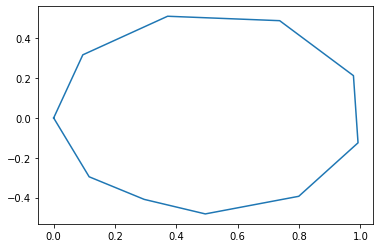


Sides:  11
Area:  0.7587484213086267


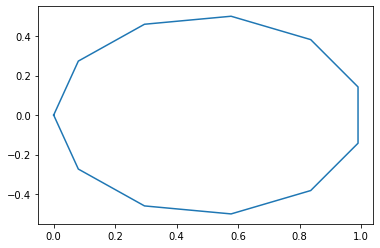


Sides:  12
Area:  0.760729846642839


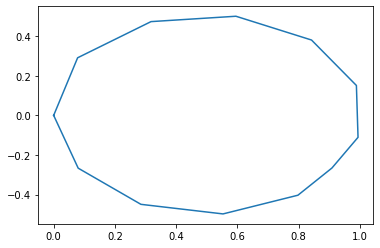

In [ ]:
min_sides = 10
max_sides = 12

# save previous solutions to plot
solutions = {}
# save last optimal value to be used as lower bound
prev_sol = 0

for sides in range(min_sides, max_sides + 1):
    print("\nProblem size: ", sides)
    solutions[sides] = solve_polar(sides, prev_sol)
    prev_sol = solutions[sides][2]

for sides in range(min_sides, max_sides + 1):
    radius, angle, area = solutions[sides]
    xs, ys = polar2cart(radius, angle)
    plot_polygon(sides, xs, ys, area)

## Second model with cartesian coordinates

There is a way to deal with orientation without using polar coordinates. It is easy to check if three points within the plane are clockwise or counter-clockwise oriented. We are going to undo the polar transformation and use new angle constraints, so that the objective and the distance constraints get simplified.

### Three points orientation

Given three points, $A=(A_x, A_y)$, $B=(B_x,B_y)$, $C=(C_x,C_y)$, we can compute the slopes of the vectors $AB$ and $BC$.

<img src="https://drive.google.com/uc?export=view&id=1Hoz9MGwWOkqp1gKuxtAgPN_eniDgXl1v" width="500" height="390">

$$AB_s = \frac{B_y-A_y}{B_x-A_x}$$
$$BC_s = \frac{C_y-B_y}{C_x-B_x}$$

If both slopes are positive, BC's slope being less (greater) than AB's implies that the three points will be (counter-)clockwise oriented. The comparison could be flipped if some of the slopes is negative, but in the end, the following expression let's us know the orientation:

$$AB_s-BC_s = \frac{B_y-A_y}{B_x-A_x}-\frac{C_y-B_y}{C_x-B_x} = \frac{(B_y-A_y)(C_x-B_x)-(C_y-B_y)(B_x-A_x)}{(B_x-A_x)(C_x-B_x)}$$

* If the numerator is positive, points are clockwise.
* If the numerator is negative, points are counter-clockwise.
* If the numerator is 0, points belong to the same line.

### Orientation in the model

As we are fixing one of the vertices (0,0), we can force all the other points to have the same orientation. For $i = 2..N-1$, we can force the same orientation for $A=(0,0)$, $B=(x_i,y_i)$, and $C=(x_{i+1},y_{i+1})$. This way, vertices are going to end up ordered. By using the previous formula, this is possible if we have the same sign in the following expression for each $i$:

$$(B_y-A_y)(C_x-B_x)-(C_y-B_y)(B_x-A_x) = y_i(x_{i+1}-x_i)-(y_{i+1}-y_i)x_i = $$
$$ = y_i x_{i+1}- y_i x_i - x_i y_{i+1} + x_i y_i = y_i x_{i+1} - x_i y_{i+1}$$

Then, we can simply add the following constraint to order our vertices counter-clockwise. For each $i = 2..N-1$:

$$y_i x_{i+1} - x_i y_{i+1} < 0$$
$$x_i y_{i+1} - y_i x_{i+1} > 0$$

By simplicity, in the model we are using the non-strict inequality. Three vertices should not be places in the same segment as that is a suboptimal solution. It would be suboptimal as the point in the middle is pointless, but the polygon could be bigger by using it (just place it in the mediatrix of two other vertices).

For further information about this formula and orientation of polygons, take a look to [Graham's scan Algorithm](https://en.wikipedia.org/wiki/Graham_scan), where the formula is used to compute convex hulls.

### Area computation with triangles

Now, we can use cartesian coordinates as variables, and simplify constraints and objective (by removing sines and cosines).

If we project a ray from the fixed vertex of the polygon to each other vertex, we are generating triangles whose area is (half of the area of the parallelogram computed via scalar product):

$$u_i = \frac{1}{2}(x_i y_{i+1} - y_i x_{i+1})$$

<img src="https://drive.google.com/uc?export=view&id=1FzeP6wz6h7ZdbS68aSVAdMrjE20ZAT4W" width="400" height="360">

The area of the polygon is equal to the sum of areas of these triangles, so we could add continuous variables $u_i$ for $i = 2..N-1$, where $u_i$ is the area of the triangle that contains vertices $(0,0)$, $(x_i,y_i)$, and $(x_{i+1},y_{i+1})$. These variables are non-negative, and at optimality, they should be equal to the area of their triangle.

Then, the objective function is rewritten as:

$$maximize \quad \sum_{i=2..N-1} u_i$$

$u_i$ should not exceed the area:

$$u_i \leq \frac{1}{2}(x_i y_{i+1} - y_i x_{i+1})$$
$$2u_i \leq x_i y_{i+1} - y_i x_{i+1}$$

So we are replacing orientation constraints with:

$$0 \leq 2u_i \leq x_i y_{i+1} - y_i x_{i+1}$$

This idea is used in state-of-the-art models such as the one published by Christian Bingane (2022), *Largest small polygons: A sequential convex optimization approach*.

### Final model

We are placing the polygon in the half-plane $y \geq 0$.

In [ ]:
%%writefile cartesian_polygon.mod

# Number of sides
param N integer > 0;
set I := 1..N;

param max_diam := 1;
# area lower bound, might help to avoid degenerated solutions
param area_lb default 0;

# Variables
var x{i in I} <= max_diam, >= -max_diam
		:=  1.5*(N-i)/(N+1)-0.5; # initial guess that could be improved
		# :=  4*i*(N + 1 - i)/(N+1)**2; # initial guess that could be improved

var y{i in I} >= 0, <= max_diam
		:=  4*i*(N + 1 - i)/(N+1)**2; # initial guess

var u{2..N-1} >= 0; # triangle area

var area >= area_lb; # objective

# Constraints
# Distance between vertices
s.t. vertices_distance{i in 1..N, j in i+1 .. N}:
	(x[i]-x[j])**2 + (y[i]-y[j])**2 <= max_diam**2;

# Orientation + Area
s.t. orientation_triangle_area{i in 2..N-1}:
    x[i]*y[i+1] - y[i]*x[i+1] >= 2*u[i];

# Fixed vertex
s.t. fix_x: x[1] = 0;
s.t. fix_y: y[1] = 0;

s.t. area_formula: area = sum{i in 2..N-1} u[i];

maximize total_area: area;

Overwriting cartesian_polygon.mod


In [ ]:
# solve the problem for n sides, return solution (cartesian coords) and area
def solve_cartesian(n, prev_sol=0):
    ampl.reset()
    ampl.read("cartesian_polygon.mod")
    ampl.param["N"] = n
    ampl.param["area_lb"] = prev_sol
    ampl.solve()

    # Get result from AMPL
    x = [ampl.var["x"][i].value() for i in range(1, n + 1)]
    y = [ampl.var["y"][i].value() for i in range(1, n + 1)]

    # To plot easier, repeat the first point in the last position
    # (to close the polygon)
    x.append(x[0])
    y.append(y[0])

    return x, y, ampl.obj["total_area"].value()

Problem size:  10
Ipopt 3.12.13: outlev=0


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 
Ipopt 3.12.13: Optimal Solution Found

suffix ipopt_zU_out OUT;
suffix ipopt_zL_out OUT;
Problem size:  11
Ipopt 3.12.13: outlev=0


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 
Ipopt 3.12.13: Optimal Solution Found

suffix

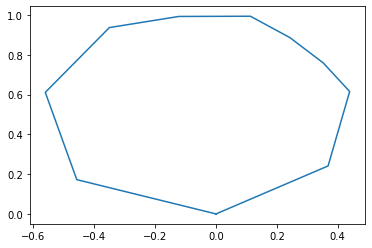


Sides:  11
Area:  0.7521931144677444


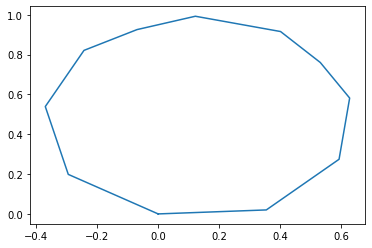


Sides:  12
Area:  0.7542668674915548


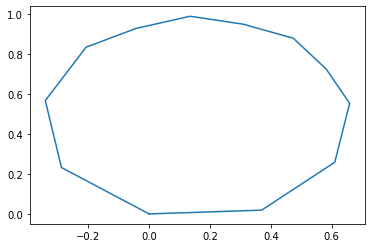

In [ ]:
min_sides = 10
max_sides = 12

# save previous solutions to plot
solutions = {}
# save last optimal value to be used as lower bound
prev_sol = 0

for sides in range(min_sides, max_sides + 1):
    print("Problem size: ", sides)
    solutions[sides] = solve_cartesian(sides, prev_sol)
    prev_sol = solutions[sides][2]

for sides in range(min_sides, max_sides + 1):
    xs, ys, area = solutions[sides]
    plot_polygon(sides, xs, ys, area)

## Conclusion

We have presented two different non-linear models to solve the Largest Small Polygon problem.

1. The first one uses **polar coordinates** to sort the vertices by the angle. It uses $2(n-1)$ variables and $n(n-1)/2+(n-1)$ constraints. However, there are sines, cosines, and quadratic terms in most of the constraints and objective, so it might be less efficient.

2. The second model uses **cartesian coordinates** and sort the vertices by another method. It gets rid of sines and cosines in constraints, and objective becomes linear by introducing $n-2$ new variables. The number of constraints is the same. This model is used in **state-of-the-art research**, and solves the problem for any $n$ without assuming symmetry, so it solves the general problem.

There are other models that might be more efficient, these assume *Graham Conjecture*, related to symmetry properties in the diameter graph.

* Multiple non-linear solvers could be used to tackle this problem when the number of sides become big: knitro, ipopt, octeract. For this particular problem, **knitro** (13.2.0) gave the best performance in terms of speed and optimality of solutions.